In [60]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('data/sepsis_final.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

for column in X.columns:
    X[column] = pd.to_numeric(X[column])
    X[column] = X[column].fillna(X[column].mean())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [111]:
import importlib
import medical_explainer_classic
importlib.reload(medical_explainer_classic)

explainer = medical_explainer_classic.explainer(
    X_train, y_train, X_test, y_test
)

| Step 1  ==> Selecting top n features
| Step 2 ==> Transforming features based on quantiles
| Step 3 ==> Fitting logistic regression model on transformed categories
| Step 4 ==> Calibrating logistic regression model


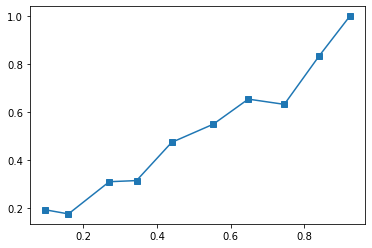

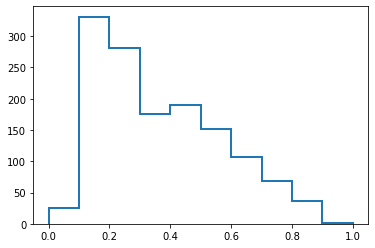

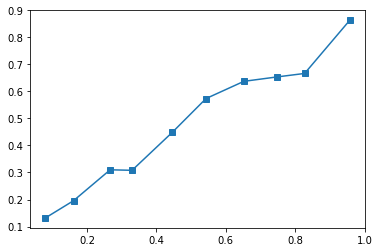

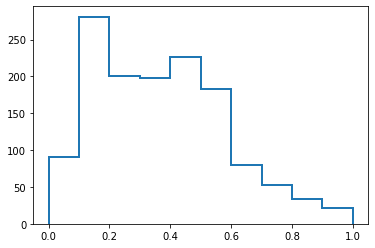

| Step 5 ==> Fit clinical score calculator
Fit clincal score calculator
Score: 0
Probability: 0.0105807081150729

Score: 1
Probability: 0.016560365013492992

Score: 2
Probability: 0.025831180853329482

Score: 3
Probability: 0.04008046071770928

Score: 4
Probability: 0.06169230391441143

Score: 5
Probability: 0.09381854998343528

Score: 6
Probability: 0.14017524701504827

Score: 7
Probability: 0.20427388015209005

Score: 8
Probability: 0.2878699697744159

Score: 9
Probability: 0.3889543081908147

Score: 10
Probability: 0.5005829783490622

Score: 11
Probability: 0.6121535629095678

Score: 12
Probability: 0.7130851724269093

Score: 13
Probability: 0.796483161374569

Score: 14
Probability: 0.8603859235620932

Score: 15
Probability: 0.9065772026159183

Score: 16
Probability: 0.9385771169448346

Score: 17
Probability: 0.9600985911284426

Score: 18
Probability: 0.9742859202406527

Score: 19
Probability: 0.9835154196530556

Score: 20
Probability: 0.9894680050956713

Score: 21
Probability: 0.99

In [112]:
explainer.fit(5, method='quantile')

In [113]:
explainer.scores

array([1., 2., 3., 1., 2., 3., 1., 3., 2., 0., 2., 4., 1., 2., 2.])

In [114]:
explainer.selected_features

array(['RDW', 'Bilirubin, Total', 'AF', 'inotropes', 'immunosuppresant'],
      dtype=object)

In [115]:
scores, probs, predictions = explainer.predict_calculator(X_test, threshold_choice=1)

In [116]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.696716446313195
Average Precision: 0.5648444244839027
Accuracy: 0.6532553035844916
[[578 266]
 [208 315]]


In [29]:
probs

array([0.51343614, 0.16164794, 0.20710263, ..., 0.2572664 , 0.2750861 ,
       0.44015768])

In [10]:
df_original = X_test
df_converted = pd.DataFrame()
i = 0
for feature in explainer.selected_features:
    if len(df_original[feature].value_counts()) < 3:
        df_converted[feature] = df_original[feature]
    else:
        range_arr = explainer.breakpoints_list[i]
        df = explainer.find_feature_categories(feature, range_arr, df_original)
        df_converted[df.columns] = df
    i += 1

In [11]:
import numpy as np
np.dot(df_converted.values, explainer.scores)

array([128., 102., 106., ..., 109., 112., 121.])

In [12]:
from scipy.special import expit
expit(np.dot(df_converted.values, explainer.scores) * explainer.unit_beta_value + np.min(explainer.beta_values) + explainer.intercept_value)

array([0.99969772, 0.99820649, 0.99863597, ..., 0.99888921, 0.99909547,
       0.99951168])

In [13]:
np.dot(df_converted.loc[3715].values, explainer.scores)

128.0

In [14]:
df_converted.loc[3715]

Hyperlipidemia <= 0.33333                  1
 0.33333 <  Hyperlipidemia <=  0.66667     0
 0.66667 <  Hyperlipidemia <=  1           0
Hyperlipidemia > 1                         0
RDW <= 13.9                                0
 13.9 <  RDW <=  15.3                      0
 15.3 <  RDW <=  17.5                      0
RDW > 17.5                                 1
Bilirubin, Total <= 0.4                    0
 0.4 <  Bilirubin, Total <=  0.7           0
 0.7 <  Bilirubin, Total <=  2.1179        0
Bilirubin, Total > 2.1179                  1
Urea Nitrogen <= 16                        1
 16 <  Urea Nitrogen <=  29                0
 29 <  Urea Nitrogen <=  54                0
Urea Nitrogen > 54                         0
Lactate <= 1.4                             0
 1.4 <  Lactate <=  2.3                    1
 2.3 <  Lactate <=  4                      0
Lactate > 4                                0
Phosphate <= 2.5                           1
 2.5 <  Phosphate <=  3.4                  0
 3.4 <  Ph

In [152]:
explainer.scores

array([21., 13.,  8., 13.,  6.,  9., 17., 23., 11.,  9., 14., 21., 10.,
       13., 14., 18.,  9., 14., 13., 18.,  9., 11., 15., 20., 11., 13.,
       18., 13.,  2., 15., 25., 13.,  0., 17., 25., 13., 10., 17., 15.,
       13.])

In [24]:
import numpy as np

scores = np.rint(explainer.beta_values / explainer.unit_beta_value)

In [25]:
np.dot(df_converted.loc[3715], scores)


-2.0

In [23]:
explainer.scores

array([21., 13.,  8., 13.,  6.,  9., 17., 23., 11.,  9., 14., 21., 10.,
       13., 14., 18.,  9., 14., 13., 18.,  9., 11., 15., 20., 11., 13.,
       18., 13.,  2., 15., 25., 13.,  0., 17., 25., 13., 10., 17., 15.,
       13.])

In [156]:
np.dot(df_converted.loc[3715].values, explainer.beta_values)

-0.15477202071672158

In [39]:
explainer.beta_values

array([ 0.56660404,  0.        , -0.35807451,  0.        , -0.48791629,
       -0.30412662,  0.30625771,  0.69431472, -0.13407928, -0.25616855,
        0.0738003 ,  0.52497706, -0.20813139, -0.0082295 ,  0.10084515,
        0.32404526, -0.25129682,  0.06854071,  0.0151152 ,  0.37617043,
       -0.30193321, -0.1396597 ,  0.13668805,  0.51343438, -0.10418015,
        0.        ,  0.31270968,  0.        , -0.72483443,  0.13387235,
        0.79949161,  0.        , -0.87789477,  0.24766996,  0.83875434,
        0.        , -0.20912444,  0.29845996,  0.11919401,  0.        ])

In [49]:
explainer.unit_beta_value *13

0.8910292430460754

In [48]:
explainer.intercept_value

0.20852952844104186

In [43]:
len(explainer.beta_values)

40